## Metric Extraction

### Requirements

1. Spacy: `conda install -c conda-forge spacy`
2. English corpus for spacy: `python -m spacy download en_core_web_sm`
3. text2num: `pip install text2num`

### Outline

In [42]:
import logging
import json

## Getting Started

### Option 1: Use Search Terms 

1. Define the `SEARCH_QUERY` variable in the cell below with a list of keywords that describe the science branch of your interest.
2. Set `USE_PUBMED_IMPORT` to `False`.
3. Run all cells & see the results.

### Option 2: Import Search Results from Pubmed 

1. Set `USE_PUBMED_IMPORT` to `True`.
2. Search for terms of interest on the Pubmed website. Use Save with Selection=All Results and Format=PMID to obtain a .txt file with PMIDs of all papers that were found.
3. Click the **Load Publication Data** cell. Run Cell > Run All Above.
4. Use widget to upload a file with IDs from Pubmed.
5. Click the **Load Publication Data** cell. Run Cell > Run All Below.

In [43]:
SEARCH_QUERY = 'brain computer interface'
USE_PUBMED_IMPORT = True

## Import PMIDs from Pubmed

In [44]:
import ipywidgets as widgets

from IPython.display import display

if USE_PUBMED_IMPORT:
    w = widgets.FileUpload(accept='.txt', multiple=False)
    display(w)

FileUpload(value={}, accept='.txt', description='Upload')

## Load Publication Data

In [45]:
from bokeh.plotting import show, output_notebook
from matplotlib import pyplot as plt


from pysrc.papers.config import PubtrendsConfig
from pysrc.papers.progress import Progress
from pysrc.papers.pm_loader import PubmedLoader
from pysrc.papers.ss_loader import SemanticScholarLoader
from pysrc.papers.analyzer_experimental import ExperimentalAnalyzer
from pysrc.papers.plotter_experimental import ExperimentalPlotter
from pysrc.papers.utils import SORT_MOST_CITED, SORT_MOST_RELEVANT, SORT_MOST_RECENT, cut_authors_list

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [46]:
SEARCH_SORT = SORT_MOST_CITED
SEARCH_PAPERS = 1000

In [47]:
config = PubtrendsConfig(test=False)
loader = PubmedLoader(config)
try:
    if USE_PUBMED_IMPORT:
        filename = list(w.value.keys())[0]
        ids = [int(chunk) for chunk in w.value[filename]['content'].decode('utf-8').split('\r\n')]
    else:
        ids = loader.search(SEARCH_QUERY, limit=SEARCH_PAPERS, sort=SEARCH_SORT)
    progress = Progress(1)
    loader.set_progress(progress)
    pub_df = loader.load_publications(ids)
finally:
    loader.close_connection()

2020-07-20 19:07:01,901 INFO: Loading publication data


## Metric Extraction

In [50]:
import re
import spacy

from collections import Counter
from spacy import displacy
from text_to_num import alpha2digit

REAL_NUMBER = re.compile(r'-?[\d]+(\.[\d]+)?')
spacy_en = spacy.load('en_core_web_sm')

In [51]:
def extract_metrics(abstract_text, visualize_dependencies=False):
    """
    Parses abstract and returns a dict of numbers with nouns that could be suitable as a metric.
    :return list of tuples (sentence, [metrics]), where metrics is a list of tuples (number, [nouns], sentence_number)
    """   
    metrics = {}
    sentences = {}
    # Convert textual numbers to digits (three -> 3)
    abstract_text = alpha2digit(abstract_text, 'en')
    # Split text into sentences and find numbers in sentences
    doc = spacy_en(abstract_text)
    for idx, sent in enumerate(doc.sents):
        sentences[idx] = sent.text
        for token in sent:
#             print(token.text, token.pos_, list(token.ancestors))
            if REAL_NUMBER.fullmatch(token.text):
                value = float(token.text) if '.' in token.text else int(token.text)
                # Analyze children and siblings, then ancestors if first was not enough
                # TODO: is there a better way?
                # TODO: use close nouns as a fallback when it is hard to find a dependency?
                # TODO: expand nouns with adjectives or other nouns? (rate -> information transfer rate)
                candidates = list(token.children) + list(token.head.children) + [token.head]
                # Explicitly ignore % (TODO: use as a unit of measurement)
                nouns = [token.text for token in filter(lambda t: t.text != '%' and t.pos_ == 'NOUN', candidates)]
                if not nouns:
                    for t in token.ancestors:
                        if t.text != '%' and t.pos_ == 'NOUN':
                            nouns = [t.text]
                            break
                for noun in nouns:
                    if noun not in metrics:
                        metrics[noun] = []
                    metrics[noun].append((value, idx))
    if visualize_dependencies:
        displacy.render(list(doc.sents), style="dep", jupyter=True)
    return metrics, sentences

### Demo `extract_metrics`

In [53]:
RANDOM_PAPER_INDEX = 0

abstract_text = pub_df['abstract'][RANDOM_PAPER_INDEX]
print(abstract_text)
metrics, _ = extract_metrics(abstract_text, visualize_dependencies=True)
for word, occasions in metrics.items():
    print(f"{word}: {occasions}")

EEG classification using Learning Vector Quantization (LVQ) is introduced on the basis of a Brain-Computer Interface (BCI) built in Graz, where a subject controlled a cursor in one dimension on a monitor using potentials recorded from the intact scalp. The method of classification with LVQ is described in detail along with first results on a subject who participated in four on-line cursor control sessions. Using this data, extensive off-line experiments were performed to show the influence of the various parameters of the classifier and the extracted features of the EEG on the classification results.


sessions: [(4, 1)]


### Class Prototype

In [90]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [91]:
# FIXME: does not seem to work

EXCLUDE = ['p300', 'hybrid']
EXCLUDE_REGEX = '|'.join(EXCLUDE)
EXCLUDE_MASK = np.logical_not(pub_df.abstract.str.contains(EXCLUDE_REGEX, flags=re.IGNORECASE, regex=True))

processed_pub_df = pub_df[EXCLUDE_MASK]

In [92]:
# Slow, currently moved out of the class to speed up fixing & rerunning the code of MetricExtractor

metrics_data = []
for _, data in pub_df.iterrows():
    paper_metrics_data = [data['id'], *extract_metrics(data['abstract'])]
    metrics_data.append(paper_metrics_data)

In [93]:
class MetricExtractor:
    def __init__(self, metrics_data):
        self.metrics_df = pd.DataFrame(metrics_data, columns=['ID', 'Metrics', 'Sentences'])
        
    def get_top_metrics(self, number=20):
        metrics_counter = Counter()
        for metric_dict in self.metrics_df['Metrics']:
            for metric, occasions in metric_dict.items():
                metrics_counter[metric] += len(occasions)
        return metrics_counter.most_common(number)
    
    def get_metric_values(self, *metrics, min_value=None, max_value=None, exclude=None, detailed=False):
        values = []
        for _, data in self.metrics_df.iterrows():
            skip = False
            metric_dict = data['Metrics']
            sentences = data['Sentences']

            # Exclude papers with unwanted terms
            if exclude:
                for word in exclude:
                    for sentence in sentences.values():
                        if word.lower() in sentence.lower():
                            skip = True
            if skip:
                continue

            for metric in metrics:
                if metric in metric_dict:
                    for value, sentence_number in metric_dict[metric]:
                        if min_value and value < min_value or max_value and value > max_value:
                            continue
                        if detailed:
                            sentence = sentences[sentence_number]
                            values.append([data['ID'], value, sentence])
                        else:
                            values.append(value)
        if detailed:
            return pd.DataFrame(values, columns=['PMID', ', '.join(metrics), 'Sentence'])
        return values

In [94]:
me = MetricExtractor(metrics_data)

In [95]:
me.metrics_df.head(1)

,ID,Metrics,Sentences
0,1286147,"{'sessions': [(4, 1)]}","{0: 'EEG classification using Learning Vector Quantization (LVQ) is introduced on the basis of a Brain-Computer Interface (BCI) built in Graz, where a subject controlled a cursor in one dimension on a monitor using potentials recorded from the intact scalp.', 1: 'The method of classification with LVQ is described in detail along with first results on a subject who participated in 4 on-line cursor control sessions.', 2: 'Using this data, extensive off-line experiments were performed to show the influence of the various parameters of the classifier and the extracted features of the EEG on the classification results.'}"


In [96]:
me.get_top_metrics()

[('subjects', 451),
 ('accuracy', 339),
 ('participants', 118),
 ('tasks', 113),
 ('channels', 77),
 ('datasets', 77),
 ('sessions', 75),
 ('methods', 73),
 ('rate', 65),
 ('bits', 62),
 ('min', 59),
 ('accuracies', 59),
 ('ms', 58),
 ('patients', 55),
 ('data', 51),
 ('°', 51),
 ('imagery', 47),
 ('types', 44),
 ('classes', 44),
 ('classification', 43)]

Text(0, 0.5, 'Number of papers')

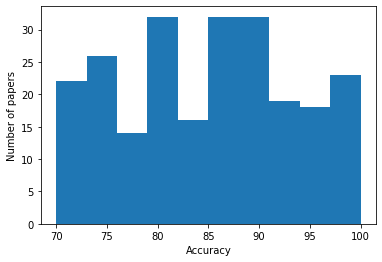

In [101]:
import matplotlib.pyplot as plt

METRIC = 'accuracy'

num_subjects = me.get_metric_values(METRIC, min_value=70, max_value=100)
plt.hist(num_subjects)
plt.xlabel('Accuracy')
plt.ylabel('Number of papers')

In [102]:
me.get_metric_values(METRIC, min_value=90, max_value=100, exclude=['p300'], detailed=True).sort_values(METRIC, ascending=False).head(10)

,PMID,accuracy,Sentence
0,9020800,100.00,"After 2 training sessions on 2 different days, 4 subjects showed a classification accuracy of 89-100%."
2,15884704,100.00,"In fact, 3 trained subjects reached 80% to 100% BCI classification accuracy in the course of the experimental sessions."
49,31936250,100.00,"All the participants successfully turned on the BCI by holding their breath for approximately 10 s (100% accuracy), and the switch system exhibited a very low FPR of 0.02 false operations per minute, which is the lowest FPR reported thus far."
53,31964514,99.33,"The best results of parameters are obtained for 4th SB as accuracy 99.33%, sensitivity 99%, specificity 99.6%, F1-Score 0.9925, and kappa value 0.9865."
21,25147509,99.21,Multiple ECoG buffer lengths were tested and the subject reached a mean online classification accuracy of 99.21% for a window length of 3.15 s.
46,31428313,99.00,"The result of this algorithm was a classification accuracy of 99% for a subject independent algorithm with less computation cost compared to traditional methods, in addition to multiple feature/classifier combinations that outperform current subject independent methods."
29,28688489,99.00,The experimental results show that all 3 classifiers achieve high performance (above 99% overall classification accuracy) for the proposed feature set.
43,31180893,98.80,"The designed system reaches a high accuracy of 97.4 ± 1.1% in the hybrid task using the C3-C4 channel configuration, which is marginally lower than the 98.8 ± 0.5% accuracy achieved with the complete set of channels while applying the support vector classifier; in the plain SSVEP task the accuracy drops from 91.3 ± 3.9% to 86.0 ± 2.5% while moving from the occipital to central area under the dual-channel condition."
23,25477777,97.80,The results show that the subject-dependent systems achieved a classification accuracy of 97.8% for discriminating visual and auditory perception processes from each other and a classification accuracy of up to 94.8% for detecting modality-specific processes independently of other cognitive activity.
37,30524257,97.50,Our proposed approach achieved a mean classification accuracy of 86.39% for limb movements over 9 subjects with a maximum individual subject classification accuracy of 97.5% for subject number 8.
